In [1]:
%pip install keras_tuner scipy seaborn --quiet

import keras_tuner
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy.stats import zscore

from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc, confusion_matrix, recall_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

Note: you may need to restart the kernel to use updated packages.


# Data Preprocessing

In [149]:
seed = 7
# df = pd.read_csv('https://media.githubusercontent.com/media/MadMoose02/COMP3608-Project/main/card_transdata.csv')
df = pd.read_csv('card_transdata.csv')
df = shuffle(df, random_state=seed)

print(f'Shape of Dataframe: {df.shape}')

Shape of Dataframe: (1000000, 8)


In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 330111 to 585903
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 68.7 MB


In [151]:
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [152]:
df['distance_from_home'] = np.log1p(df['distance_from_home'])
df['distance_from_last_transaction'] = np.log1p(df['distance_from_last_transaction'])
df['ratio_to_median_purchase_price'] = np.log1p(df['ratio_to_median_purchase_price'])

In [163]:
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,2.489694,1.006892,0.826152,0.881536,0.350399,0.100608,0.650552,0.087403
std,1.201064,0.973274,0.574956,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004863,0.000118,0.004390,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.584737,0.259800,0.389114,1.000000,0.000000,0.000000,0.000000,0.000000
50%,2.394960,0.692472,0.692005,1.000000,0.000000,0.000000,1.000000,0.000000
75%,3.286310,1.471496,1.130231,1.000000,1.000000,0.000000,1.000000,0.000000
max,9.271786,9.380261,5.593979,1.000000,1.000000,1.000000,1.000000,1.000000


# Initial Visualisations of Dataset

### Boxplot

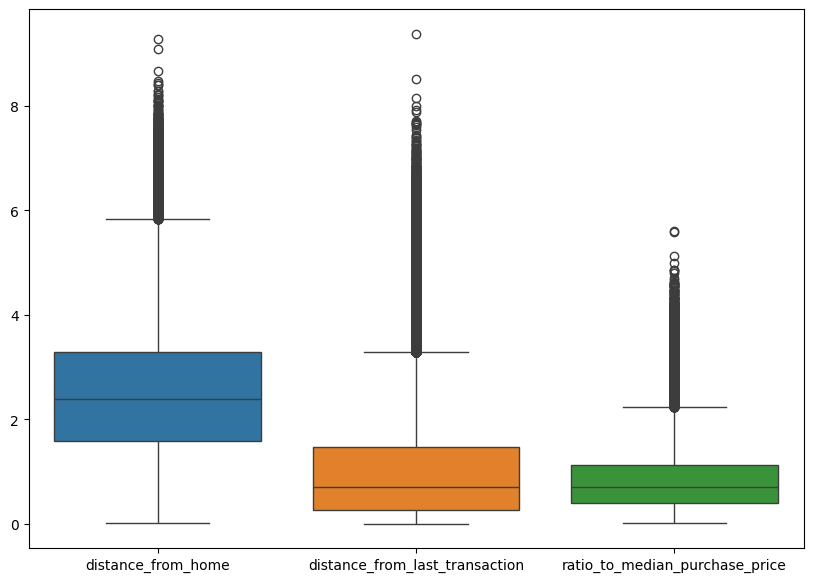

In [113]:
plt.figure(figsize=(10, 7))
sns.boxplot(data=df[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']])
plt.savefig('all_boxplot_outliers.png', dpi=300)
plt.show()

### Correlation Matrix Heatmap

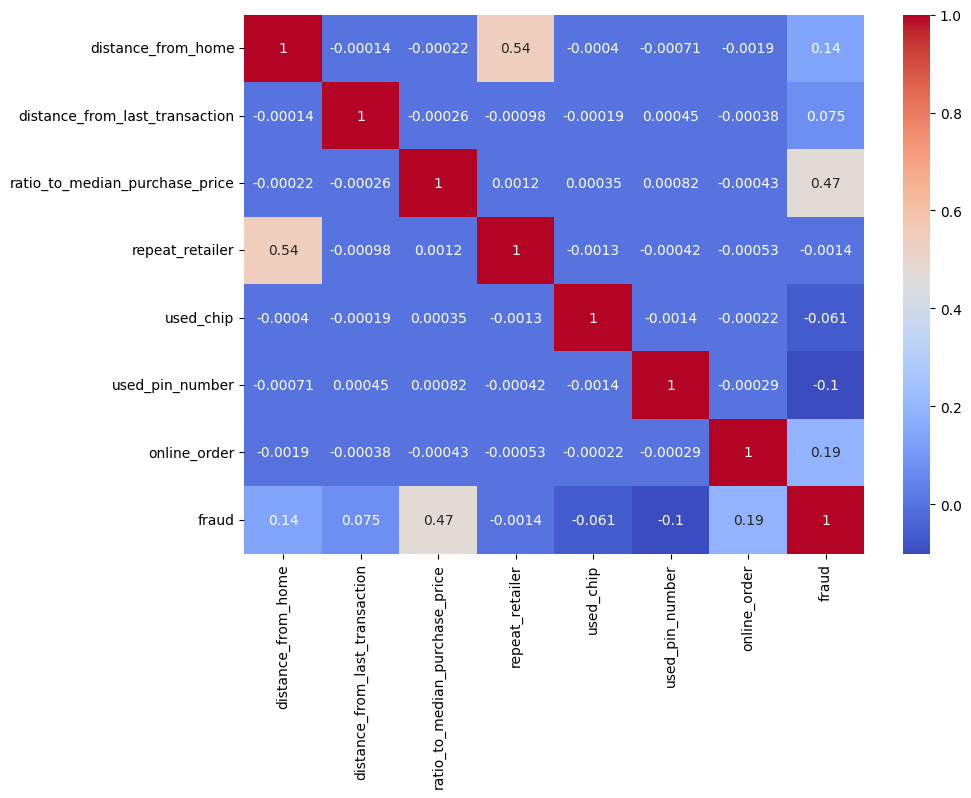

In [114]:
corr_matrix = df.corr()
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

### Pairplot

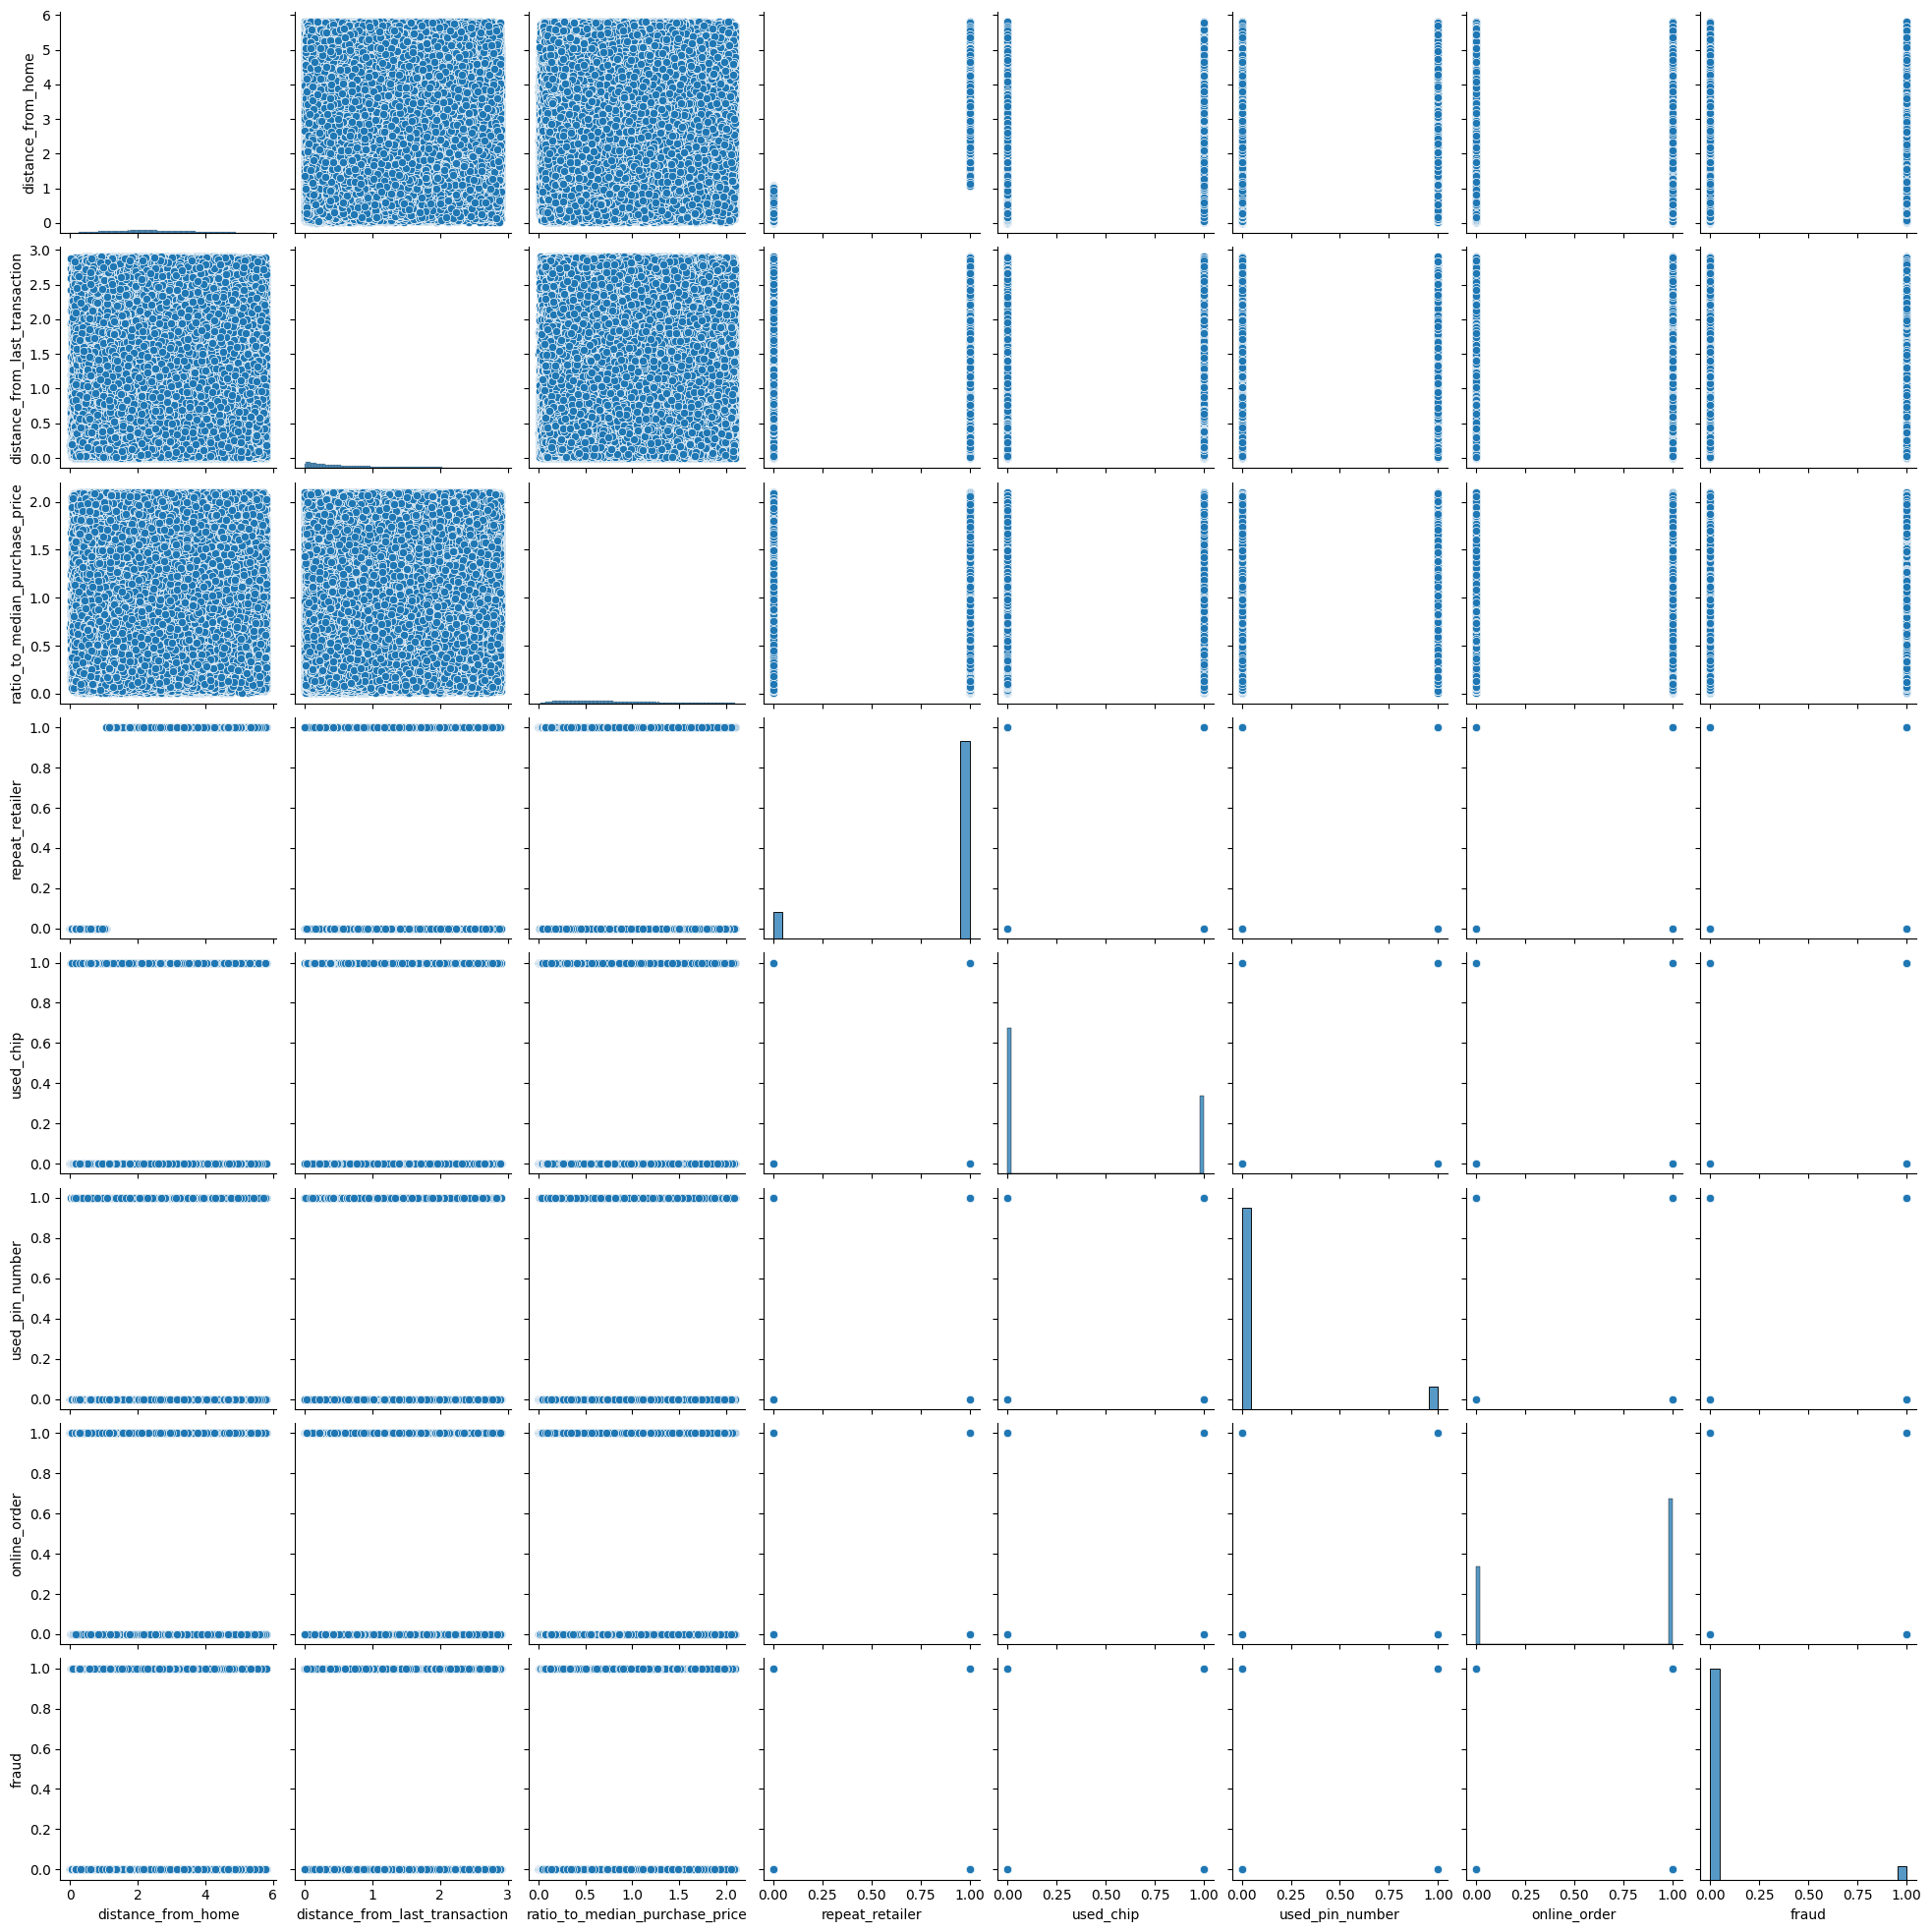

In [148]:
sns.pairplot(df)
plt.savefig('pairplot_outliers.png', dpi=300)
plt.show()

# Data Cleaning

In [10]:
def plot_attribute_graphs(df, attribute):
    plot_df = df.sample(frac=0.3, random_state=seed)
    features = plot_df.columns.drop(attribute)
    fig, axs = plt.subplots(len(features), figsize=(14, 4*len(features)))

    for i, feature in enumerate(features):
        axs[i].scatter(plot_df[attribute], plot_df[feature])
        axs[i].set_xlabel(attribute)
        axs[i].set_ylabel(feature)
        axs[i].set_title(f'{feature} vs. {attribute}', fontsize=15)

    plt.tight_layout()
    plt.show()

def plot_attribute_outlier_graphs(df, attribute):
    plot_df = df.sample(frac=0.3, random_state=seed)
    features = plot_df.columns.drop([attribute, 'z_score_' + attribute, 'colour', 'size'])
    fig, axs = plt.subplots(len(features), figsize=(14, 4*len(features)))

    for i, feature in enumerate(features):
        axs[i].scatter(plot_df[attribute], plot_df[feature], c=plot_df['colour'], s=plot_df['size'])
        axs[i].set_xlabel(attribute)
        axs[i].set_ylabel(feature)
        axs[i].set_title(f'{feature} vs. {attribute}', fontsize=15)

    plt.tight_layout()
    plt.show()

def generate_zscore(df, attribute, threshold):
    df['z_score_' + attribute] = zscore(df[attribute])
    df['colour'] = df['z_score_' + attribute].apply(lambda x: 'red' if x > threshold else 'blue')
    df['size'] = df['z_score_' + attribute].apply(lambda x: 40 if x > threshold else 20)
    outliers = df[df['z_score_' + attribute].abs() > threshold]
    print(f'Found {len(outliers)} outliers')

def remove_outliers(df, attribute, threshold):
    df = df[df['z_score_' + attribute].abs() <= threshold]
    df = df.drop(['z_score_' + attribute, 'colour', 'size'], axis=1)
    return df

## Distance from Home

In [153]:
threshold = 3
attribute = 'distance_from_home'
generate_zscore(df, attribute, threshold)
# plot_attribute_outlier_graphs(df, attribute)

Found 3416 outliers


In [154]:
df = remove_outliers(df, attribute, threshold)
# plot_attribute_graphs(df, attribute)

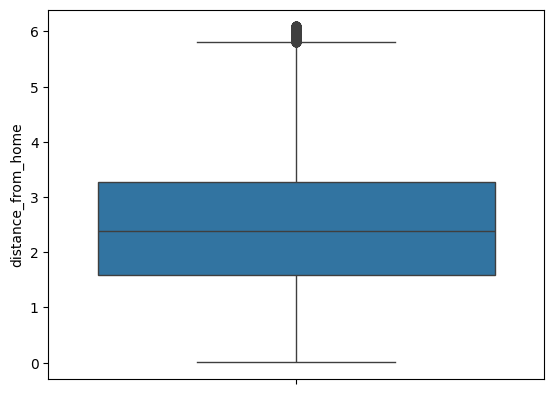

In [155]:
plt.figure()
sns.boxplot(data=df['distance_from_home'])
plt.show()

In [156]:
IQR = df['distance_from_home'].quantile(0.75) - df['distance_from_home'].quantile(0.25)
print("IQR", " "*8, IQR.round(6))
print(df['distance_from_home'].describe())

IQR          1.693659
count    996584.000000
mean          2.475887
std           1.179480
min           0.004863
25%           1.581847
50%           2.389580
75%           3.275506
max           6.092844
Name: distance_from_home, dtype: float64


In [157]:
fraud_outliers = df[
    (df['distance_from_home'] < df['distance_from_home'].quantile(0.25) - 1.5 * IQR) | 
    (df['distance_from_home'] > df['distance_from_home'].quantile(0.75) + 1.5 * IQR) &
    (df['fraud'] == 1)
]
genuine_outliers = df[
    (df['distance_from_home'] < df['distance_from_home'].quantile(0.25) - 1.5 * IQR) | 
    (df['distance_from_home'] > df['distance_from_home'].quantile(0.75) + 1.5 * IQR) &
    (df['fraud'] == 0)
]
print("# fraud trans:", len(fraud_outliers))
print("# genuine trans:", len(genuine_outliers))

# fraud trans: 1186
# genuine trans: 1519


In [158]:
# remove the outliers
df = df[~df.isin(fraud_outliers)].dropna()
df = df[~df.isin(genuine_outliers)].dropna()

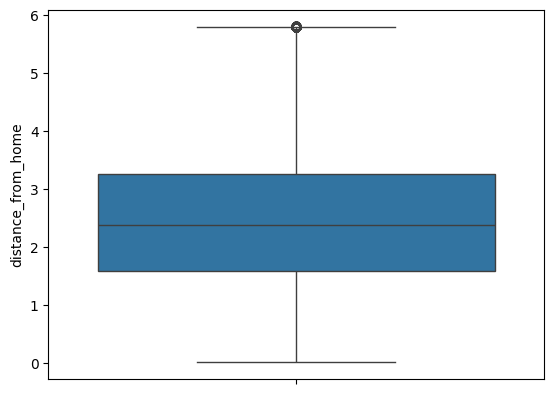

In [31]:
plt.figure()
sns.boxplot(data=df['distance_from_home'])
plt.show()

## Distance from Last Transaction

In [159]:
threshold = 3
attribute = 'distance_from_last_transaction'
generate_zscore(df, attribute, threshold)
# plot_attribute_outlier_graphs(df, attribute)

Found 14862 outliers


In [160]:
df = remove_outliers(df, attribute, threshold)
# plot_attribute_graphs(df, attribute)

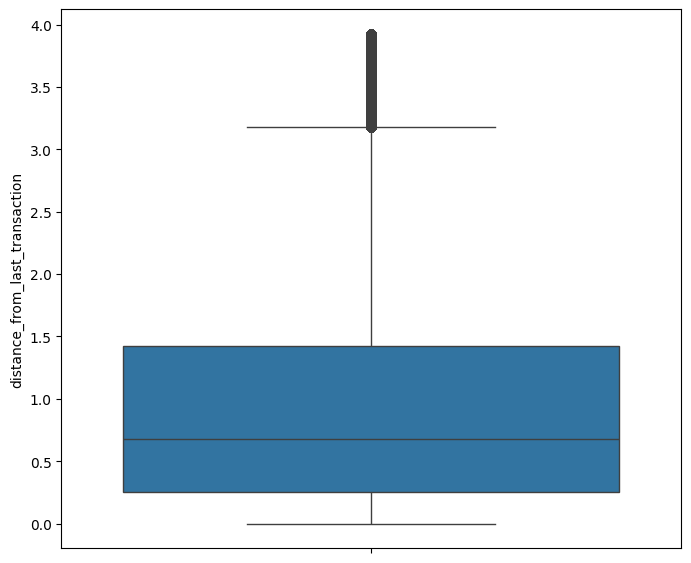

In [161]:
plt.figure(figsize=(8, 7))
sns.boxplot(data=df['distance_from_last_transaction'])
plt.show()

In [162]:
IQR = df['distance_from_last_transaction'].quantile(0.75) - df['distance_from_last_transaction'].quantile(0.25)
print("IQR", " "*8, IQR.round(6))
print(df['distance_from_last_transaction'].describe())

IQR          1.168407
count    979017.000000
mean          0.953047
std           0.873120
min           0.000118
25%           0.254919
50%           0.675839
75%           1.423326
max           3.926944
Name: distance_from_last_transaction, dtype: float64


In [163]:
fraud_outliers = df[
    (df['distance_from_last_transaction'] < df['distance_from_last_transaction'].quantile(0.25) - 1.5 * IQR) | 
    (df['distance_from_last_transaction'] > df['distance_from_last_transaction'].quantile(0.75) + 1.5 * IQR) &
    (df['fraud'] == 1)
]
genuine_outliers = df[
    (df['distance_from_last_transaction'] < df['distance_from_last_transaction'].quantile(0.25) - 1.5 * IQR) | 
    (df['distance_from_last_transaction'] > df['distance_from_last_transaction'].quantile(0.75) + 1.5 * IQR) &
    (df['fraud'] == 0)
]
print("# fraud trans:", len(fraud_outliers))
print("# genuine trans:", len(genuine_outliers))

# fraud trans: 2015
# genuine trans: 23439


In [164]:
df = df[~df.isin(fraud_outliers)].dropna()
df = df[~df.isin(genuine_outliers)].dropna()

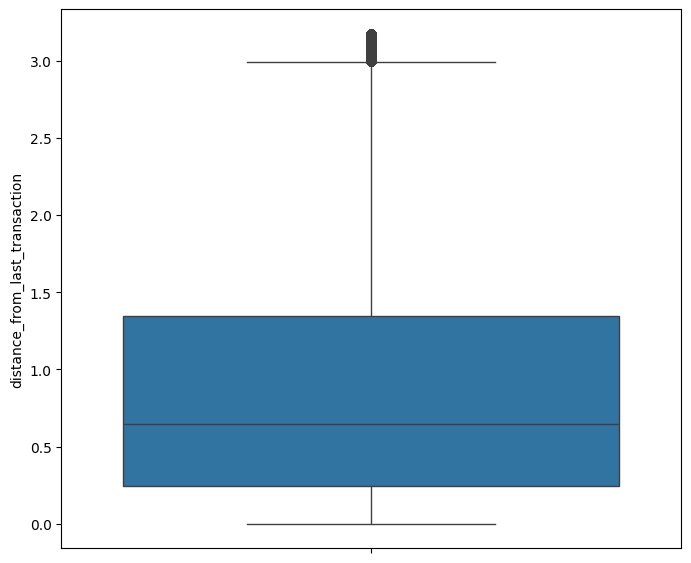

In [165]:
plt.figure(figsize=(8, 7))
sns.boxplot(data=df['distance_from_last_transaction'])
plt.show()

In [166]:
above_threshold = df[df['distance_from_last_transaction'] > 2.9]
print("Number of transactions above threshold:", len(above_threshold))
print("Number of fraud transactions above threshold:", len(above_threshold[above_threshold['fraud'] == 1]))
print("Number of genuine transactions above threshold:", len(above_threshold[above_threshold['fraud'] == 0]))

Number of transactions above threshold: 16051
Number of fraud transactions above threshold: 1287
Number of genuine transactions above threshold: 14764


In [167]:
df = df[~df.isin(above_threshold)].dropna()

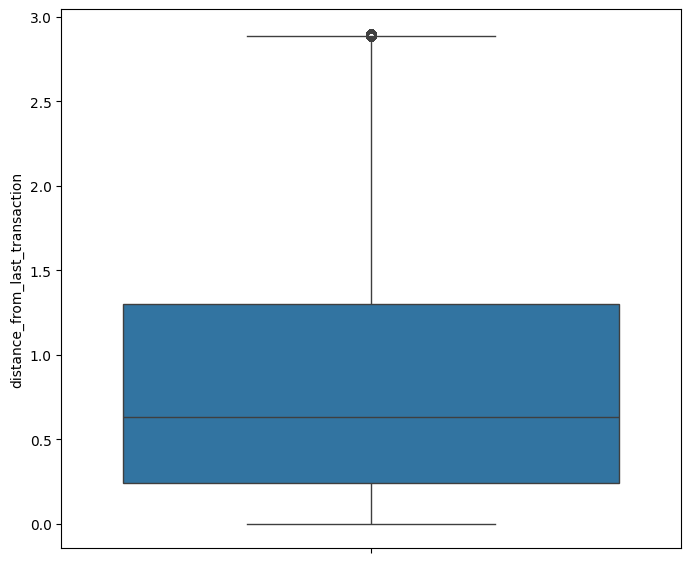

In [139]:
plt.figure(figsize=(8, 7))
sns.boxplot(data=df['distance_from_last_transaction'])
plt.savefig('dist_from_last_trans_boxplot_clean.png', bbox_inches='tight', dpi=300)
plt.show()

## Ratio to Median Purchase Price

In [168]:
threshold = 3
attribute = 'ratio_to_median_purchase_price'
generate_zscore(df, attribute, threshold)
# plot_attribute_outlier_graphs(df, attribute)

Found 11436 outliers


In [169]:
df = remove_outliers(df, attribute, threshold)
# plot_attribute_graphs(df, attribute)

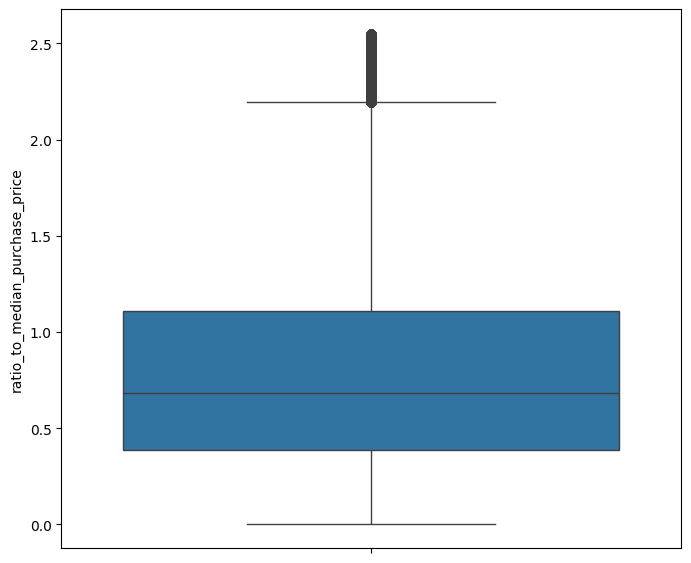

In [170]:
plt.figure(figsize=(8, 7))
sns.boxplot(data=df['ratio_to_median_purchase_price'])
plt.show()

In [171]:
IQR = df['ratio_to_median_purchase_price'].quantile(0.75) - df['ratio_to_median_purchase_price'].quantile(0.25)
print("IQR", " "*8, IQR.round(6))
print(df['ratio_to_median_purchase_price'].describe())

IQR          0.723401
count    926076.000000
mean          0.800428
std           0.528362
min           0.004390
25%           0.385666
50%           0.683563
75%           1.109067
max           2.551113
Name: ratio_to_median_purchase_price, dtype: float64


In [172]:
fraud_outliers = df[
    (df['ratio_to_median_purchase_price'] < df['ratio_to_median_purchase_price'].quantile(0.25) - 1.5 * IQR) | 
    (df['ratio_to_median_purchase_price'] > df['ratio_to_median_purchase_price'].quantile(0.75) + 1.5 * IQR) &
    (df['fraud'] == 1)
]
genuine_outliers = df[
    (df['ratio_to_median_purchase_price'] < df['ratio_to_median_purchase_price'].quantile(0.25) - 1.5 * IQR) | 
    (df['ratio_to_median_purchase_price'] > df['ratio_to_median_purchase_price'].quantile(0.75) + 1.5 * IQR) &
    (df['fraud'] == 0)
]
print("# fraud trans:", len(fraud_outliers))
print("# genuine trans:", len(genuine_outliers))

# fraud trans: 9874
# genuine trans: 6037


In [173]:
df = df[~df.isin(fraud_outliers)].dropna()
df = df[~df.isin(genuine_outliers)].dropna()

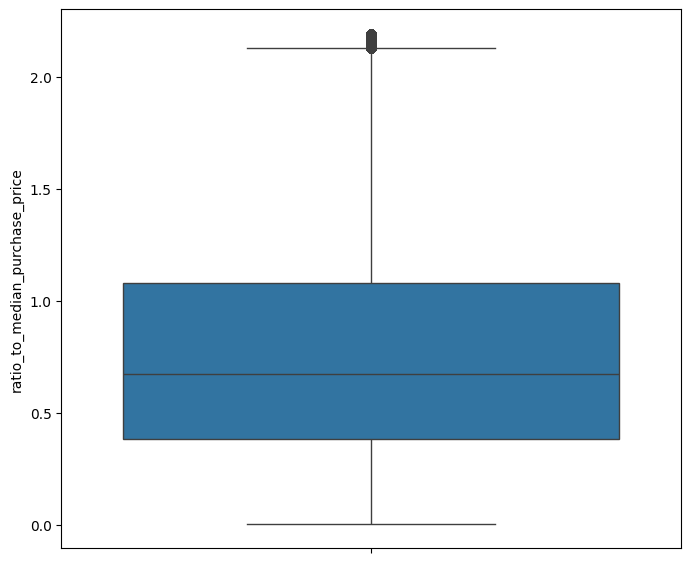

In [174]:
plt.figure(figsize=(8, 7))
sns.boxplot(data=df['ratio_to_median_purchase_price'])
plt.show()

In [175]:
above_threshold = df[df['ratio_to_median_purchase_price'] > 2.1]
print("Number of transactions above threshold:", len(above_threshold))
print("Number of fraud transactions above threshold:", len(above_threshold[above_threshold['fraud'] == 1]))
print("Number of genuine transactions above threshold:", len(above_threshold[above_threshold['fraud'] == 0]))

Number of transactions above threshold: 6697
Number of fraud transactions above threshold: 4139
Number of genuine transactions above threshold: 2558


In [176]:
df = df[~df.isin(above_threshold)].dropna()

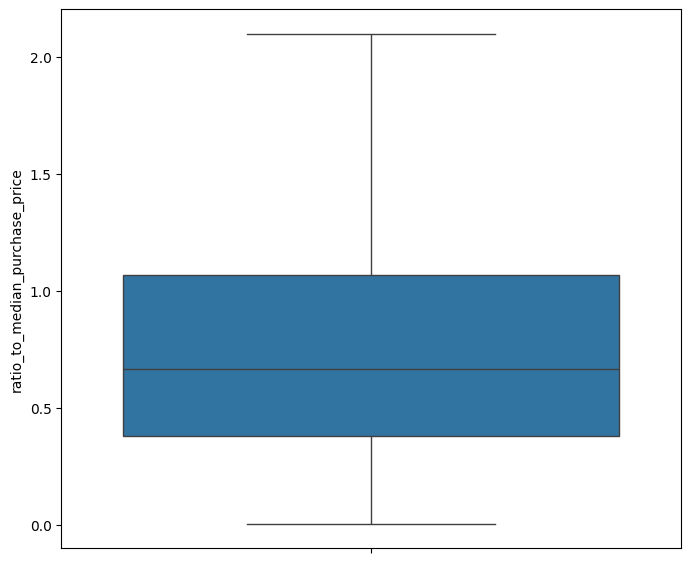

In [98]:
plt.figure(figsize=(8, 7))
sns.boxplot(data=df['ratio_to_median_purchase_price'])
plt.savefig('ratio_to_median_purchase_price_boxplot_clean.png', bbox_inches='tight', dpi=300)
plt.show()

## Final Visualisation of Dataset

In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 903468 entries, 330111 to 585903
Data columns (total 8 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   distance_from_home              903468 non-null  float64
 1   distance_from_last_transaction  903468 non-null  float64
 2   ratio_to_median_purchase_price  903468 non-null  float64
 3   repeat_retailer                 903468 non-null  float64
 4   used_chip                       903468 non-null  float64
 5   used_pin_number                 903468 non-null  float64
 6   online_order                    903468 non-null  float64
 7   fraud                           903468 non-null  float64
dtypes: float64(8)
memory usage: 62.0 MB


In [141]:
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,903468.000000,903468.000000,903468.000000,903468.000000,903468.000000,903468.000000,903468.000000,903468.000000
mean,2.466332,0.848531,0.763180,0.880963,0.350394,0.100522,0.650424,0.058885
std,1.166753,0.730999,0.478451,0.323832,0.477094,0.300694,0.476836,0.235410
min,0.004863,0.000118,0.004390,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.579443,0.241622,0.379050,1.000000,0.000000,0.000000,0.000000,0.000000
50%,2.384654,0.630756,0.667322,1.000000,0.000000,0.000000,1.000000,0.000000
75%,3.266658,1.299597,1.068522,1.000000,1.000000,0.000000,1.000000,0.000000
max,5.815980,2.899996,2.099992,1.000000,1.000000,1.000000,1.000000,1.000000


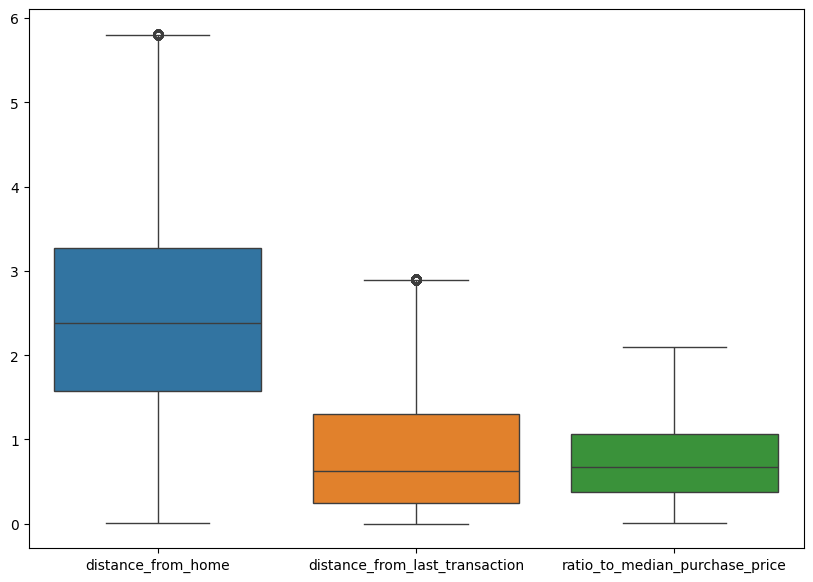

In [142]:
plt.figure(figsize=(10, 7))
sns.boxplot(data=df[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']])
plt.savefig('all_boxplot_clean.png', dpi=300)
plt.show()

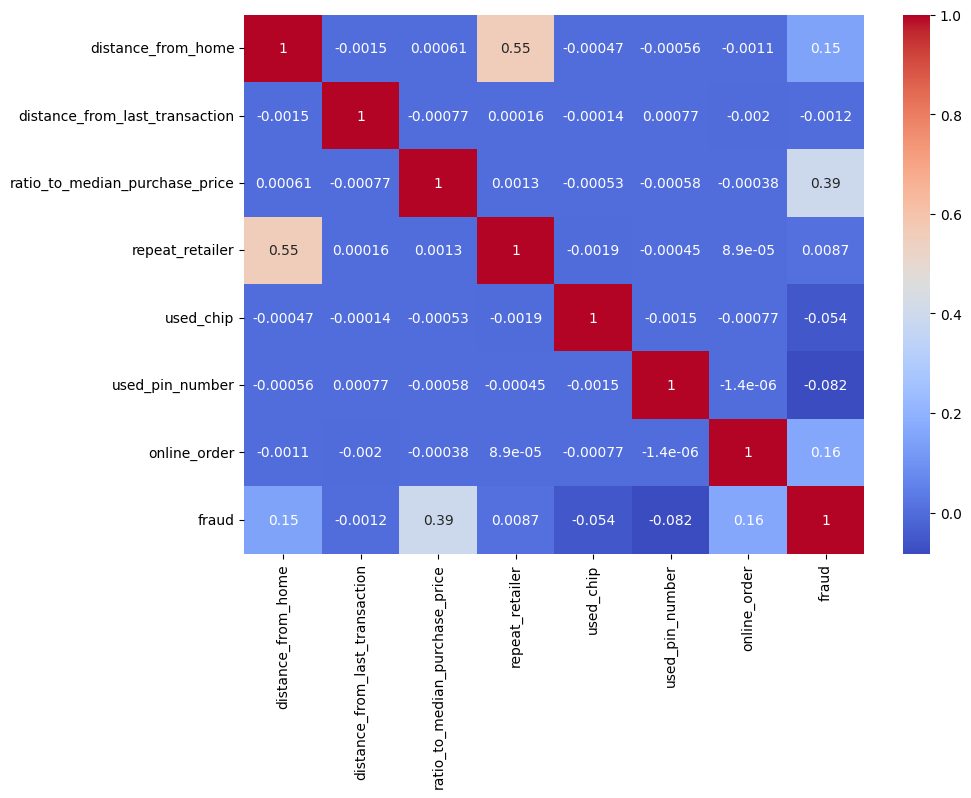

In [143]:
corr_matrix = df.corr()
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

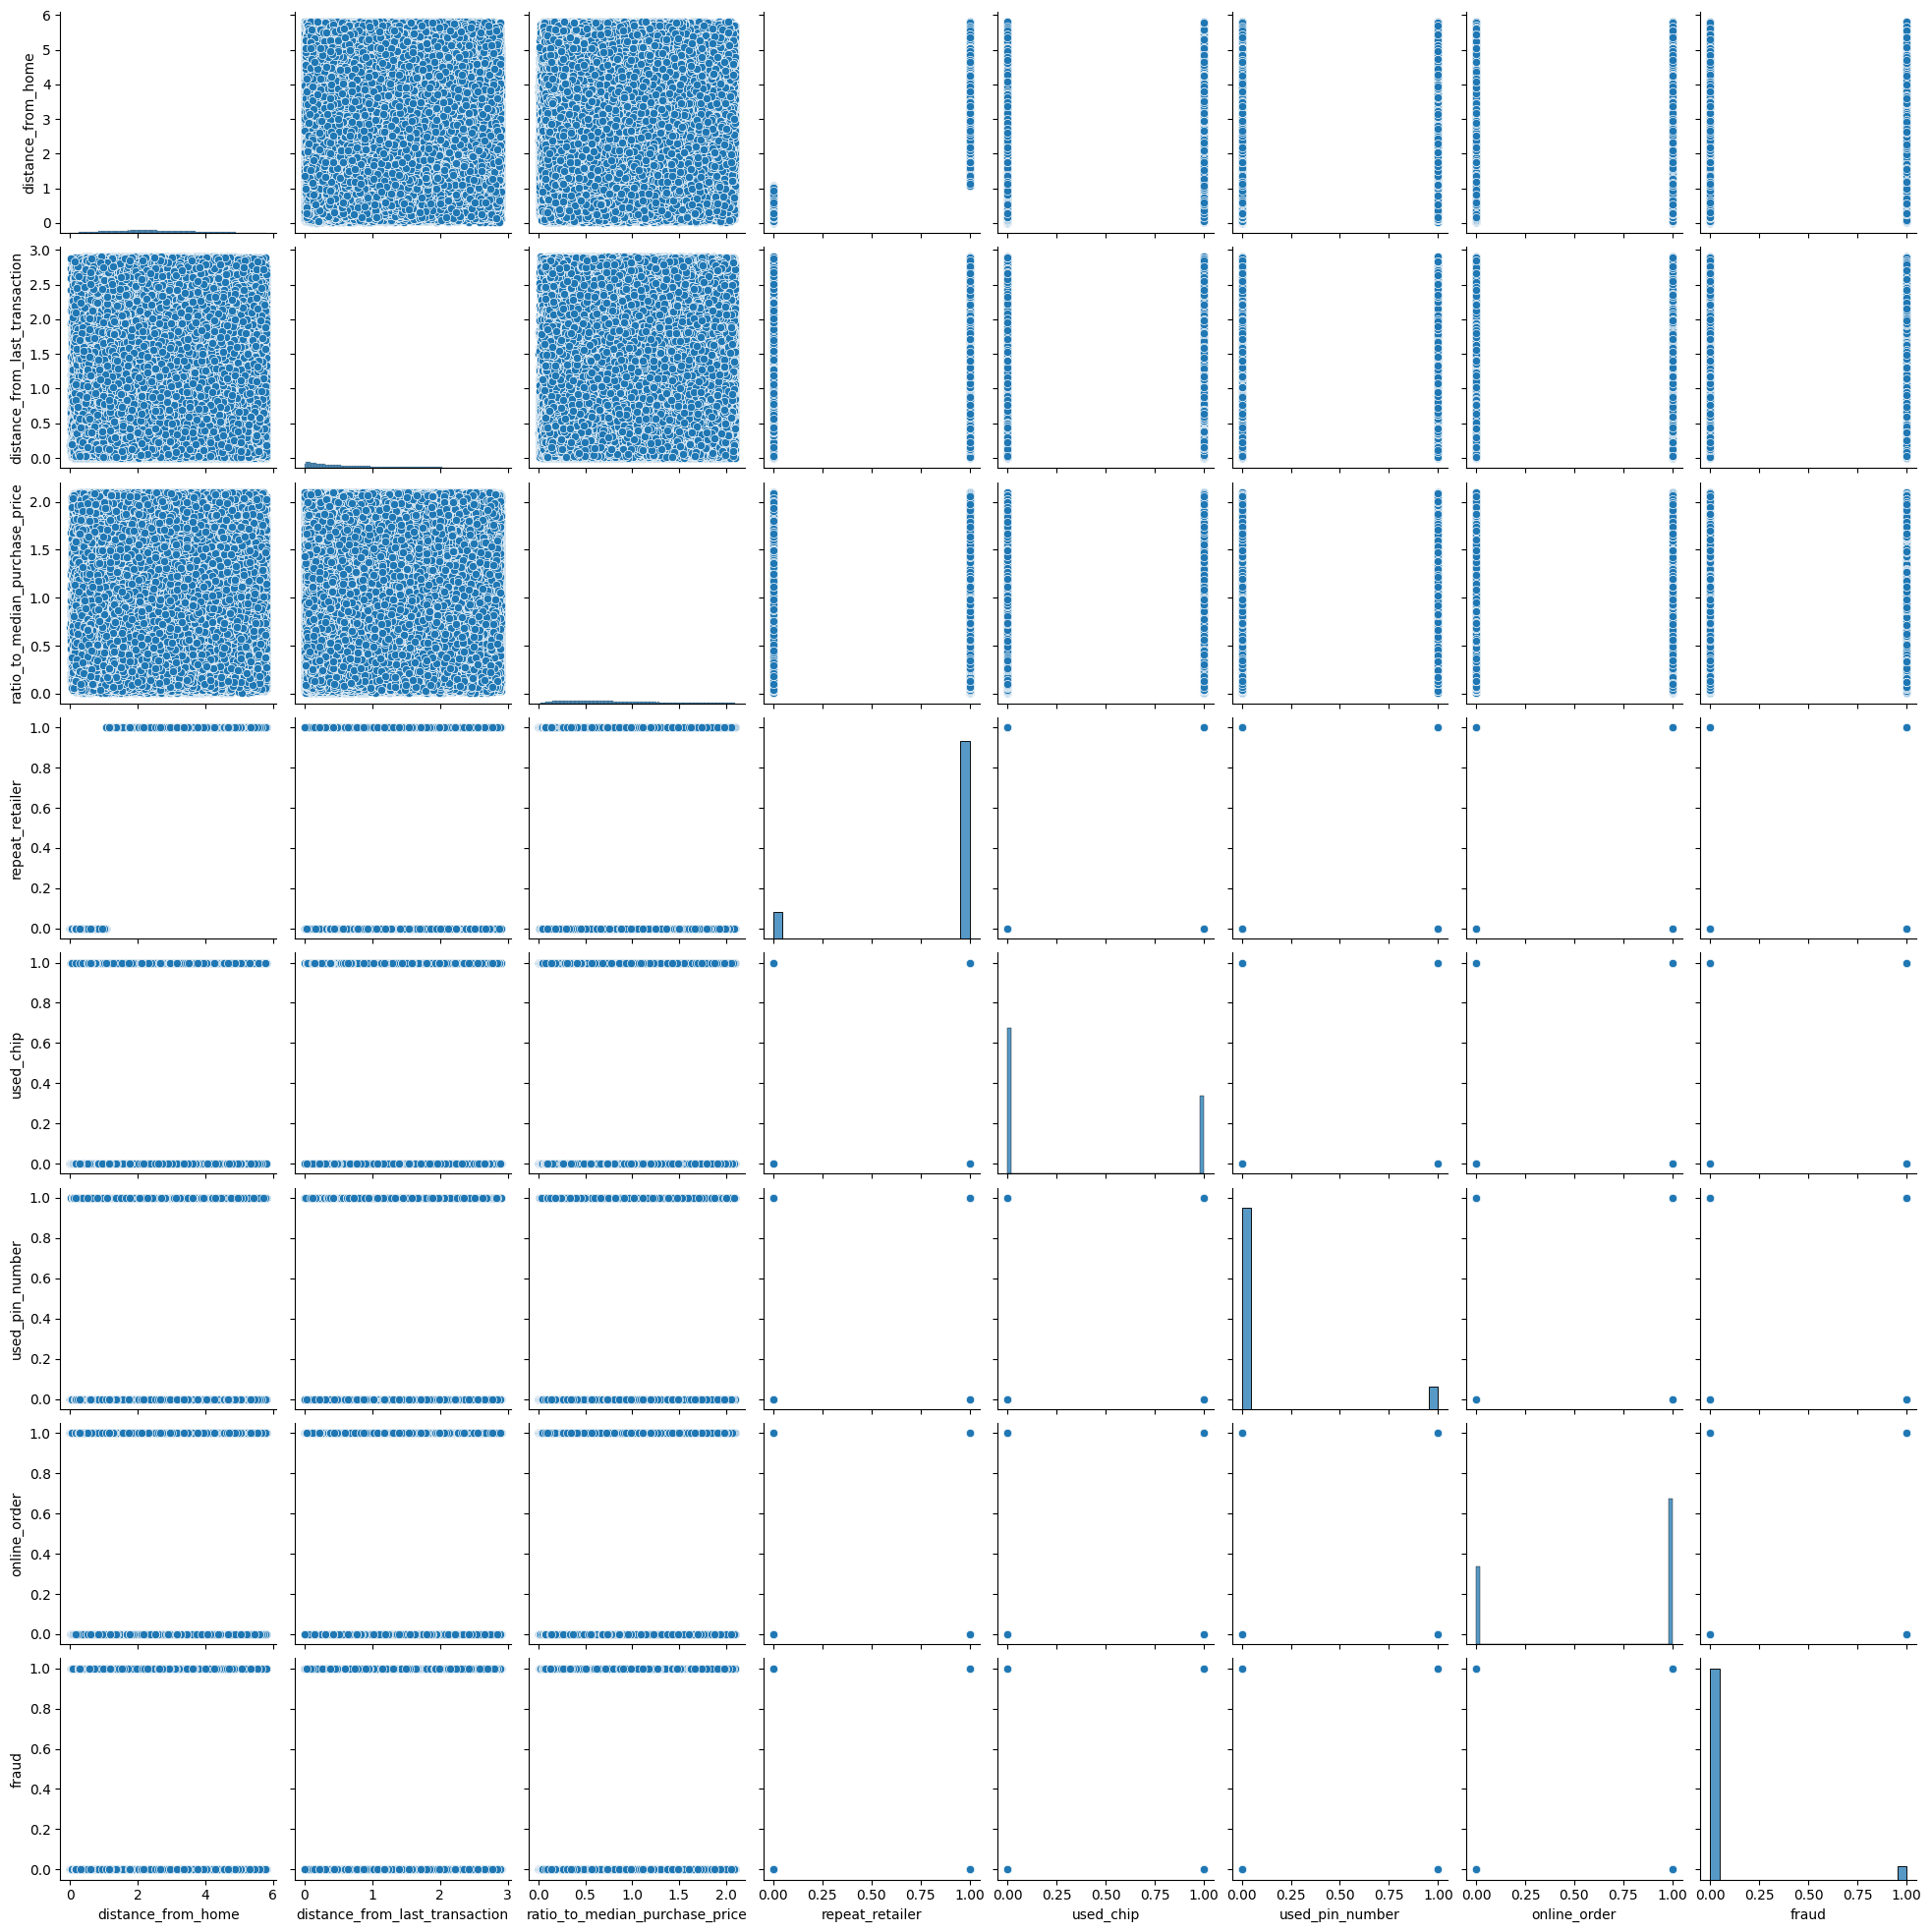

In [147]:
sns.pairplot(df)
plt.savefig('pairplot_clean.png', dpi=300)
plt.show()

# Data Partitioning

In [186]:
def x_y_variables(df: pd.DataFrame):
    X = df[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price', 
            'repeat_retailer', 'used_chip', 'used_pin_number', 'online_order']]
    return X, df['fraud']

The dataset is split into 3 different datasets that will then be used to train each of the three models.

To effectively detect fraud, our foremost goal is to ensure an equitable distribution of positive fraud records across all three datasets. This is achieved by stratifying the split based on the target variable.

In [234]:
# Separate fraud and non-fraud records
fraud, no_fraud = df[df['fraud'] == 1], df[df['fraud'] == 0]

# Create 3 partitions of (mostly) equal size
df = shuffle(pd.concat([fraud, no_fraud]))
even_distr = int(df.shape[0]/3)
df1 = df.head(even_distr)
df2 = df.iloc[even_distr + 1 : (even_distr * 2) + 1]
df3 = df.tail(even_distr)

# Display statistics
print(f"Amount of fraud records: {fraud.shape[0]}")
print(f"Amount of Non-fraud records: {no_fraud.shape[0]}")
print(f"Amount allocated to each dataset: {even_distr}")
print(f"Sizes of partitioned DataFrames: {df1.shape}, {df2.shape}, {df3.shape}")

Amount of fraud records: 53201
Amount of Non-fraud records: 850267
Amount allocated to each dataset: 301156
Sizes of partitioned DataFrames: (301156, 8), (301156, 8), (301156, 8)


# Classification Models

## Logistic Regression

In [185]:
X, y = x_y_variables(df1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state=seed)
X_train, y_train = np.array(X_train), np.array(y_train)

print(f'Train Shape: {X_train.shape}, Test Shape: {X_test.shape}')

Train Shape: (225867, 7), Test Shape: (75289, 7)


In [187]:
t_logit = LogisticRegression(random_state=seed)
t_logit.fit(X_train, y_train)
y_nw = t_logit.predict(X_test)

print(f'Recall: {recall_score(y_test, y_nw)}')
print(f'Confusion Matrix:\n{confusion_matrix(y_test, y_nw)}\n')
print(classification_report(y_test, y_nw))

Recall: 0.5208796090626389
Confusion Matrix:
[[70036   751]
 [ 2157  2345]]

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     70787
         1.0       0.76      0.52      0.62      4502

    accuracy                           0.96     75289
   macro avg       0.86      0.76      0.80     75289
weighted avg       0.96      0.96      0.96     75289



c:\Users\kesha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


#### Hyperparameter Tuning

In [189]:
logit = LogisticRegression(max_iter=3000, verbose=1, random_state=seed)

param_grid = {
    'C': [0.1, 0.2, 0.3, 0.4],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(estimator=logit, param_grid=param_grid, cv=10)
grid_search.fit(X_train, y_train)
best_C = grid_search.best_params_['C']
best_penalty = grid_search.best_params_['penalty']
best_solver = grid_search.best_params_['solver']

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]convergence after 14 epochs took 1 seconds
convergence after 14 epochs took 2 seconds
convergence after 13 epochs took 1 seconds
convergence after 12 epochs took 2 seconds
convergence after 14 epochs took 1 seconds
convergence after 13 epochs took 2 seconds
convergence after 13 epochs took 1 seconds
convergence after 14 epochs took 2 seconds
convergence after 14 epochs took 2 seconds
convergence after 14 epochs took 1 seconds
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]convergence after 13 epochs took 2 seconds
convergence after 13 epochs took 1 seconds
convergence after 12 epochs took 2 seconds
convergence after 12 epochs took 1 seconds
convergence after 13 epochs took 1 seconds
convergence after 12 epochs took 2 seconds
convergence after 12 epochs took 1 seconds
convergence after 13 epochs took 1 seconds
conver

In [190]:
print('Best generalisation coeff (C):', best_C)
print('Best penalty type:', best_penalty)
print('Best solver:', best_solver)
print('Recall with best hyper parameters:', grid_search.best_score_)

Best generalisation coeff (C): 0.1
Best penalty type: l2
Best solver: liblinear
Recall with best hyper parameters: 0.9626815817470714


#### Tuned Logistic Regression model

In [202]:
best_logit = LogisticRegression(C=best_C, penalty=best_penalty, solver=best_solver, random_state=seed)
best_logit.fit(X_train, y_train)
y_hat = best_logit.predict_proba(X_test)
y_scores = y_hat[:,1]
y_pred = [1 if prob > 0.4 else 0 for prob in y_scores]

print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n')
print(classification_report(y_test, y_pred))

c:\Users\kesha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Recall: 0.5866281652598845
Confusion Matrix:
[[69636  1151]
 [ 1861  2641]]

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98     70787
         1.0       0.70      0.59      0.64      4502

    accuracy                           0.96     75289
   macro avg       0.84      0.79      0.81     75289
weighted avg       0.96      0.96      0.96     75289



#### ROC-AUC Curve

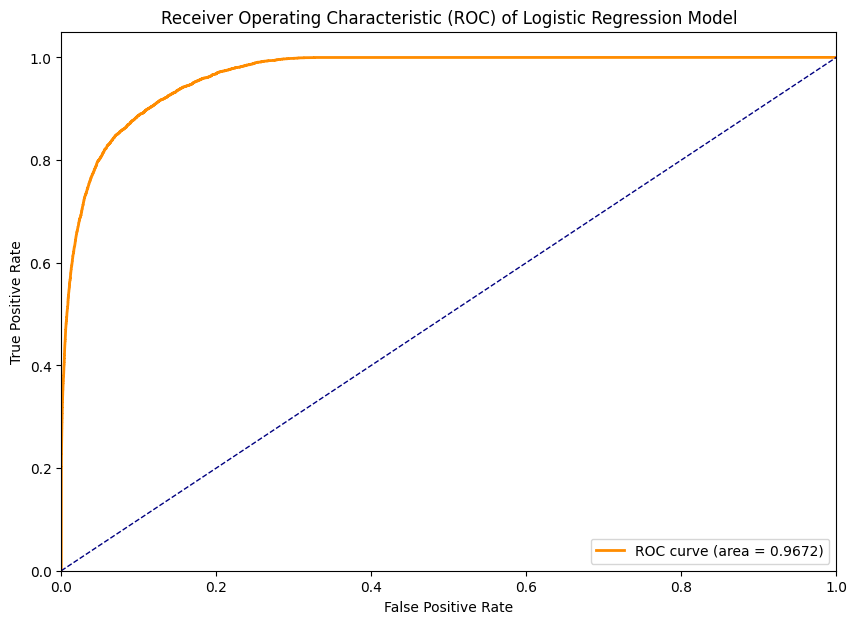

In [102]:
y_proba = best_logit.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) of Logistic Regression Model')
plt.legend(loc="lower right")
plt.show()

## Artificial Neural Network (ANN)

In [244]:
X, y = x_y_variables(df2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
X_train, y_train = np.array(X_train), np.array(y_train)

#### Base Model 

In [248]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(
    optimizer='SGD',
    loss=tf.keras.losses.BinaryCrossentropy(),      
    metrics=[tf.keras.metrics.Recall()]
)

model.fit(X_train, y_train, epochs=20)
loss, metrics = model.evaluate(X_test, y_test)

Epoch 1/20


7059/7059 ━━━━━━━━━━━━━━━━━━━━ 5s 666us/step - loss: 0.2377 - recall_5: 0.0442
Epoch 2/20
7059/7059 ━━━━━━━━━━━━━━━━━━━━ 5s 635us/step - loss: 0.1157 - recall_5: 0.3353
Epoch 3/20
7059/7059 ━━━━━━━━━━━━━━━━━━━━ 5s 642us/step - loss: 0.0969 - recall_5: 0.4827
Epoch 4/20
7059/7059 ━━━━━━━━━━━━━━━━━━━━ 4s 613us/step - loss: 0.0812 - recall_5: 0.5798
Epoch 5/20
7059/7059 ━━━━━━━━━━━━━━━━━━━━ 5s 636us/step - loss: 0.0656 - recall_5: 0.6695
Epoch 6/20
7059/7059 ━━━━━━━━━━━━━━━━━━━━ 4s 617us/step - loss: 0.0548 - recall_5: 0.7449
Epoch 7/20
7059/7059 ━━━━━━━━━━━━━━━━━━━━ 4s 628us/step - loss: 0.0462 - recall_5: 0.7992
Epoch 8/20
7059/7059 ━━━━━━━━━━━━━━━━━━━━ 4s 620us/step - loss: 0.0419 - recall_5: 0.8239
Epoch 9/20
7059/7059 ━━━━━━━━━━━━━━━━━━━━ 5s 644us/step - loss: 0.0383 - recall_5: 0.8491
Epoch 10/20
7059/7059 ━━━━━━━━━━━━━━━━━━━━ 4s 629us/step - loss: 0.0355 - recall_5: 0.8656
Epoch 11/20
7059/7059 ━━━━━━━━━━━━━━━━━━━━ 5s 639us/step - loss: 0.0337 - recall_5: 0.8765
Epoch 12/20
7059/70

In [249]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

print(f"Recall: {metrics}")
print(f'Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n')
print(classification_report(y_test, y_pred))

2353/2353 ━━━━━━━━━━━━━━━━━━━━ 2s 626us/step
Recall: 0.9075091481208801
Confusion Matrix:
[[70860    61]
 [  404  3964]]

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     70921
         1.0       0.98      0.91      0.94      4368

    accuracy                           0.99     75289
   macro avg       0.99      0.95      0.97     75289
weighted avg       0.99      0.99      0.99     75289



#### Build Custom ANN Model with Keras

In [236]:
def build_model(hp):
    model = tf.keras.models.Sequential()
    model.add(
        tf.keras.layers.Dense(
            hp.Choice('units',[32, 64, 128, 256, 512]), 
            activation='relu'
        )
    )
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer='SGD',
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.Recall()]
    )
    return model

#### Hyperparameter Tuning
Hyper Parameter tuning to determine the amount of nuerons to be used in the hidden layer of the ANN.

In [238]:
obj = keras_tuner.Objective('val_recall', direction='max')
tuner = keras_tuner.RandomSearch(build_model, objective=obj, max_trials=6)

In [239]:
tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Trial 5 Complete [00h 02m 24s]
val_recall: 0.9656593203544617

Best val_recall So Far: 0.976190447807312
Total elapsed time: 00h 12m 15s


In [240]:
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="val_recall", direction="max")

Trial 3 summary
Hyperparameters:
units: 512
Score: 0.976190447807312

Trial 2 summary
Hyperparameters:
units: 64
Score: 0.9709249138832092

Trial 4 summary
Hyperparameters:
units: 128
Score: 0.9656593203544617

Trial 0 summary
Hyperparameters:
units: 32
Score: 0.9642857313156128

Trial 1 summary
Hyperparameters:
units: 256
Score: 0.9583333134651184


#### K-fold Cross Validation

In [ ]:
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
scores_collection = []

In [ ]:
for train, test in kfold.split(X, y):
    model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(64, activation='relu') ,
      tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer = 'SGD',
        loss = tf.keras.losses.BinaryCrossentropy(),
        metrics = [tf.keras.metrics.Recall()]
    )

    model.fit(X_train,y_train, epochs=30)
    score = model.evaluate(X_test,y_test)
    scores_collection.append(score[1] * 100)
    print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

print("%.2f%% (+/- %.2f%%)" % (np.mean(scores_collection), np.std(scores_collection)))

Epoch 1/30
7295/7295 ━━━━━━━━━━━━━━━━━━━━ 5s 643us/step - loss: 0.2513 - recall_5: 0.0254
Epoch 2/30
7295/7295 ━━━━━━━━━━━━━━━━━━━━ 5s 637us/step - loss: 0.1114 - recall_5: 0.4329
Epoch 3/30
7295/7295 ━━━━━━━━━━━━━━━━━━━━ 5s 655us/step - loss: 0.0932 - recall_5: 0.5614
Epoch 4/30
7295/7295 ━━━━━━━━━━━━━━━━━━━━ 5s 660us/step - loss: 0.0747 - recall_5: 0.6539
Epoch 5/30
7295/7295 ━━━━━━━━━━━━━━━━━━━━ 5s 648us/step - loss: 0.0582 - recall_5: 0.7432
Epoch 6/30
7295/7295 ━━━━━━━━━━━━━━━━━━━━ 5s 626us/step - loss: 0.0486 - recall_5: 0.8078
Epoch 7/30
7295/7295 ━━━━━━━━━━━━━━━━━━━━ 5s 639us/step - loss: 0.0429 - recall_5: 0.8386
Epoch 8/30
7295/7295 ━━━━━━━━━━━━━━━━━━━━ 5s 626us/step - loss: 0.0393 - recall_5: 0.8589
Epoch 9/30
7295/7295 ━━━━━━━━━━━━━━━━━━━━ 5s 637us/step - loss: 0.0370 - recall_5: 0.8751
Epoch 10/30
7295/7295 ━━━━━━━━━━━━━━━━━━━━ 5s 616us/step - loss: 0.0353 - recall_5: 0.8876
Epoch 11/30
7295/7295 ━━━━━━━━━━━━━━━━━━━━ 5s 638us/step - loss: 0.0334 - recall_5: 0.8939
Epoch 12

#### Tuned ANN Evaluation

In [241]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(
    optimizer='SGD',
    loss=tf.keras.losses.BinaryCrossentropy(),      
    metrics=[tf.keras.metrics.Recall()]
)
model.fit(X_train, y_train, epochs=30)
loss, metrics = model.evaluate(X_test, y_test)

Epoch 1/30


7059/7059 ━━━━━━━━━━━━━━━━━━━━ 5s 662us/step - loss: 0.2345 - recall_2: 0.0341
Epoch 2/30
7059/7059 ━━━━━━━━━━━━━━━━━━━━ 5s 655us/step - loss: 0.1094 - recall_2: 0.3602
Epoch 3/30
7059/7059 ━━━━━━━━━━━━━━━━━━━━ 5s 634us/step - loss: 0.0877 - recall_2: 0.5253
Epoch 4/30
7059/7059 ━━━━━━━━━━━━━━━━━━━━ 5s 641us/step - loss: 0.0687 - recall_2: 0.6381
Epoch 5/30
7059/7059 ━━━━━━━━━━━━━━━━━━━━ 5s 639us/step - loss: 0.0535 - recall_2: 0.7438
Epoch 6/30
7059/7059 ━━━━━━━━━━━━━━━━━━━━ 5s 642us/step - loss: 0.0454 - recall_2: 0.8030
Epoch 7/30
7059/7059 ━━━━━━━━━━━━━━━━━━━━ 4s 629us/step - loss: 0.0402 - recall_2: 0.8384
Epoch 8/30
7059/7059 ━━━━━━━━━━━━━━━━━━━━ 5s 634us/step - loss: 0.0369 - recall_2: 0.8608
Epoch 9/30
7059/7059 ━━━━━━━━━━━━━━━━━━━━ 5s 640us/step - loss: 0.0346 - recall_2: 0.8722
Epoch 10/30
7059/7059 ━━━━━━━━━━━━━━━━━━━━ 5s 647us/step - loss: 0.0327 - recall_2: 0.8786
Epoch 11/30
7059/7059 ━━━━━━━━━━━━━━━━━━━━ 5s 697us/step - loss: 0.0313 - recall_2: 0.8896
Epoch 12/30
7059/70

In [243]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

print(f"Recall: {metrics}")
print(f'Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n')
print(classification_report(y_test, y_pred))

   1/2353 ━━━━━━━━━━━━━━━━━━━━ 48s 21ms/step

2353/2353 ━━━━━━━━━━━━━━━━━━━━ 2s 702us/step
Recall: 0.932692289352417
Confusion Matrix:
[[70864    57]
 [  294  4074]]

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     70921
         1.0       0.99      0.93      0.96      4368

    accuracy                           1.00     75289
   macro avg       0.99      0.97      0.98     75289
weighted avg       1.00      1.00      1.00     75289



#### ROC-AUC Curve

2353/2353 ━━━━━━━━━━━━━━━━━━━━ 2s 767us/step


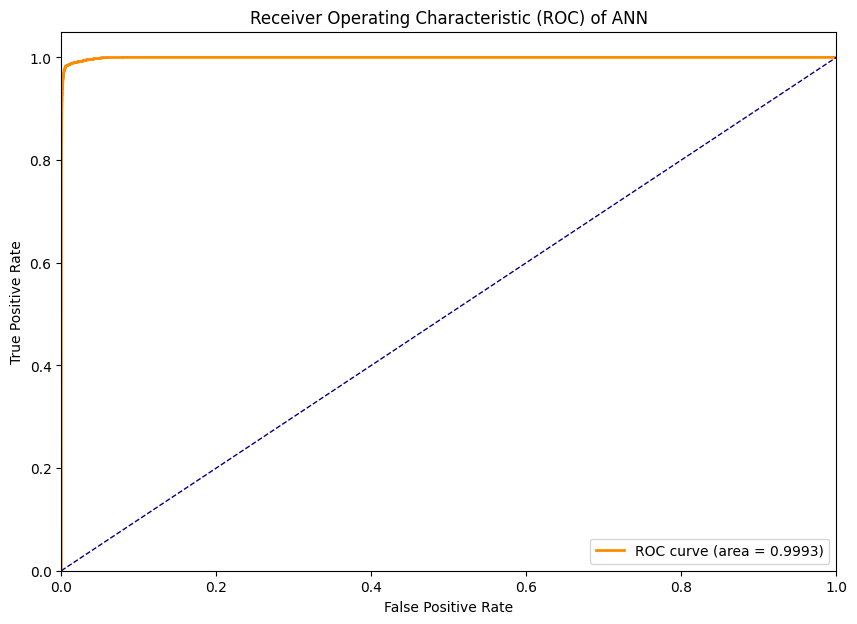

In [215]:
y_pred = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) of ANN')
plt.legend(loc="lower right")
plt.show()

## Random Forest Classification

In [216]:
def print_sample_stats(df):
    print("*Training Samples*")
    print(f'# of fraud records: {y[y==1].size}\n# of non-fraud records: {y[y==0].size}')
    print("\n*Test Samples*")
    print(f'# of fraud records: {y_test[y_test==1].size}\n# of non-fraud records: {y_test[y_test==0].size}\n')

#### Base Model

In [217]:
X, y = x_y_variables(df3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
X_train, y_train = np.array(X_train), np.array(y_train)
print_sample_stats(df3)

*Training Samples*
# of fraud records: 17565
# of non-fraud records: 283591

*Test Samples*
# of fraud records: 4452
# of non-fraud records: 70837



In [218]:
rf = RandomForestClassifier(random_state=seed)
rf.fit(X_train, y_train)
y_hat = rf.predict(X_test)
print(f'Recall: {recall_score(y_test,y_hat)}')
print(f'Confusion Matrix:\n{confusion_matrix(y_test,y_hat)}\n\n')
print(classification_report(y_test, y_hat))

c:\Users\kesha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Recall: 0.9997753818508536
Confusion Matrix:
[[70837     0]
 [    1  4451]]


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     70837
         1.0       1.00      1.00      1.00      4452

    accuracy                           1.00     75289
   macro avg       1.00      1.00      1.00     75289
weighted avg       1.00      1.00      1.00     75289



#### K-fold Cross Validation

In [74]:
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=seed)
scores_collection = []

In [75]:
for x, (train, test) in enumerate(kfold.split(X, y)):
    rf = RandomForestClassifier(random_state=seed)
    rf.fit(X_test, y_test)
    y_hat = rf.predict(X_test)
    score = recall_score(y_test, y_hat)
    scores_collection.append(score * 100 )
    print(f'Iteration: {x + 1}, Recall: {score*100}')

print(f'Overall Recall: {np.mean(scores_collection)}, STD: {np.std(scores_collection)}')

Iteration: 1, Recall: 100.0
Iteration: 2, Recall: 100.0
Iteration: 3, Recall: 100.0
Iteration: 4, Recall: 100.0
Iteration: 5, Recall: 100.0
Iteration: 6, Recall: 100.0
Overall Recall: 100.0, STD: 0.0


#### ROC-AUC Curve

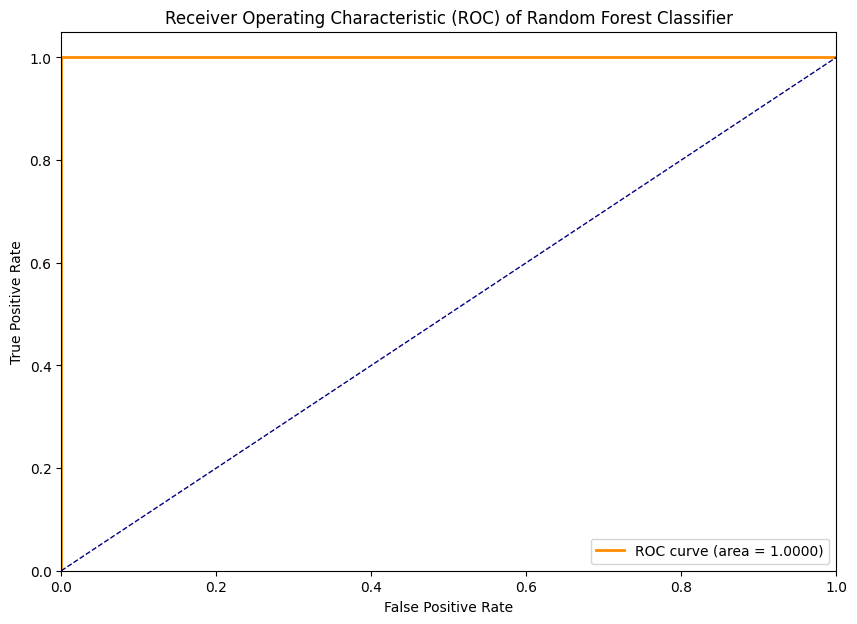

In [77]:
probs = rf.predict_proba(X_test)
probs = probs[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) of Random Forest Classifier')
plt.legend(loc="lower right")
plt.show()

#### Testing Random Forest Classification on Full Dataset

In [219]:
df_copy = shuffle(df)
X, y = x_y_variables(df_copy)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
X_train, y_train = np.array(X_train), np.array(y_train)
print_sample_stats(df_copy)

*Training Samples*
# of fraud records: 53201
# of non-fraud records: 850267

*Test Samples*
# of fraud records: 16035
# of non-fraud records: 255006



In [221]:
rf_full = RandomForestClassifier(random_state=seed)
rf_full.fit(X_train, y_train)
y_hat = rf_full.predict(X_test)
print(f'Recall: {recall_score(y_test,y_hat)}')
print(f'Confusion Matrix:\n{confusion_matrix(y_test,y_hat)}\n\n')
print(classification_report(y_test, y_hat))

c:\Users\kesha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Recall: 1.0
Confusion Matrix:
[[255006      0]
 [     0  16035]]


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    255006
         1.0       1.00      1.00      1.00     16035

    accuracy                           1.00    271041
   macro avg       1.00      1.00      1.00    271041
weighted avg       1.00      1.00      1.00    271041



#### Testing Random Forest Classification on All 3 Dataset Partitions

In [222]:
even_distr = int(df_copy.shape[0]/3)
df1 = df_copy.head(even_distr)
df2 = df_copy.iloc[even_distr + 1 : (even_distr * 2) + 1]
df3 = df_copy.tail(even_distr)

print(f'Amount allocated to each dataset: {even_distr}')
print("Sizes of partitioned DataFrames: " + str(df1.shape) + ", " + str(df2.shape) + ", " + str(df3.shape))

Amount allocated to each dataset: 301156
Sizes of partitioned DataFrames: (301156, 8), (301156, 8), (301156, 8)


##### Partition 1

In [223]:
X, y = x_y_variables(df1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
X_train, y_train = np.array(X_train), np.array(y_train)
print_sample_stats(df1)

*Training Samples*
# of fraud records: 17851
# of non-fraud records: 283305

*Test Samples*
# of fraud records: 5378
# of non-fraud records: 84969



In [224]:
rf1 = RandomForestClassifier(random_state=seed)
rf1.fit(X_train, y_train)
y_hat = rf1.predict(X_test)
print(f'Recall: {recall_score(y_test,y_hat)}')
print(f'Confusion Matrix:\n{confusion_matrix(y_test,y_hat)}\n\n')
print(classification_report(y_test, y_hat))

c:\Users\kesha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Recall: 1.0
Confusion Matrix:
[[84969     0]
 [    0  5378]]


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     84969
         1.0       1.00      1.00      1.00      5378

    accuracy                           1.00     90347
   macro avg       1.00      1.00      1.00     90347
weighted avg       1.00      1.00      1.00     90347



##### Partition 2

In [225]:
X, y = x_y_variables(df2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
X_train, y_train = np.array(X_train), np.array(y_train)
print_sample_stats(df2)

*Training Samples*
# of fraud records: 17622
# of non-fraud records: 283534

*Test Samples*
# of fraud records: 5320
# of non-fraud records: 85027



In [226]:
rf2 = RandomForestClassifier(random_state=seed)
rf2.fit(X_train, y_train)
y_hat = rf2.predict(X_test)
print(f'Recall: {recall_score(y_test,y_hat)}')
print(f'Confusion Matrix:\n{confusion_matrix(y_test,y_hat)}\n\n')
print(classification_report(y_test, y_hat))

c:\Users\kesha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Recall: 0.9998120300751879
Confusion Matrix:
[[85027     0]
 [    1  5319]]


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     85027
         1.0       1.00      1.00      1.00      5320

    accuracy                           1.00     90347
   macro avg       1.00      1.00      1.00     90347
weighted avg       1.00      1.00      1.00     90347



##### Partition 3

In [227]:
X, y = x_y_variables(df3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
X_train, y_train = np.array(X_train), np.array(y_train)
print_sample_stats(df3)

*Training Samples*
# of fraud records: 17728
# of non-fraud records: 283428

*Test Samples*
# of fraud records: 5257
# of non-fraud records: 85090



In [228]:
rf3 = RandomForestClassifier(random_state=seed)
rf3.fit(X_train, y_train)
y_hat = rf3.predict(X_test)
print(f'Recall: {recall_score(y_test,y_hat)}')
print(f'Confusion Matrix:\n{confusion_matrix(y_test,y_hat)}\n\n')
print(classification_report(y_test, y_hat))

c:\Users\kesha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Recall: 0.9996195548792087
Confusion Matrix:
[[85090     0]
 [    2  5255]]


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     85090
         1.0       1.00      1.00      1.00      5257

    accuracy                           1.00     90347
   macro avg       1.00      1.00      1.00     90347
weighted avg       1.00      1.00      1.00     90347



# Conclusion

As shown in the results above, the Random Forest model is able to achieve an almost perfect recall score of $0.999$. 

In addition, the ROC-AUC showed a perfect area of $1.000$. Therefore, the Random Forest model is able to accurately predict the fraud transactions of this dataset.